In [ ]:
import os
import sys
import numpy as np
import gc
import h5py
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset
from data.NoisyDataset import NoisyDataset, FullNoisyDataset

In [12]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'

In [16]:
def load_pnet(
        net, state_dict, build_graph, random_init,
        ff_multiplier, fb_multiplier, er_multiplier,
        same_param, device='cuda:0'):
    
    if same_param:
        raise Exception('Not implemented!')
    else:
        pnet = PNetClass(
            net, build_graph=build_graph, random_init=random_init,
            ff_multiplier=ff_multiplier, fb_multiplier=fb_multiplier, er_multiplier=er_multiplier
            )

    pnet.load_state_dict(state_dict)
    pnet.eval()
    pnet.to(device)
    return pnet

In [17]:

# Path names
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'

In [18]:
fb_state_dict_path = f'{checkpoints_dir}{pnet_name}/{pnet_name}-50-regular.pth'
fb_state_dict = torch.load(fb_state_dict_path)

In [19]:

net = BranchedNetwork() # Load original network
net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))

<All keys matched successfully>

In [21]:
EPOCH = 15

SAME_PARAM = False           # to use the same parameters for all pcoders or not
FF_START = True             # to start from feedforward initialization
MAX_TIMESTEP = 5

In [22]:
pnet = load_pnet(
        net, fb_state_dict, build_graph=True, random_init=(not FF_START),
        ff_multiplier=0.33, fb_multiplier=0.33, er_multiplier=0.0,
        same_param=SAME_PARAM, device='cuda:0'
        )

In [23]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

In [24]:
f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [25]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [26]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [28]:
import pickle

In [29]:
with open(f"{engram_dir}PsychophysicsWord2017W_net_performance.p", 'rb') as f:
    net_mistakes = pickle.load(f)['net_mistakes']

In [137]:
result_dict = {}
for snr_bg in np.unique(f_metadata['orig_dset']):
    result_dict[snr_bg.decode('utf_8')] = np.mean(net_mistakes[np.where(f_metadata['orig_dset'] == snr_bg)])


In [138]:
keys = sorted(result_dict.keys())

In [139]:
print(keys)
              
keys.remove('TimitDry')
keys.remove('WSJDry')

['TimitDry', 'Timit_AudScene_0db', 'Timit_AudScene_3db', 'Timit_AudScene_neg3db', 'Timit_AudScene_neg6db', 'Timit_AudScene_neg9db', 'Timit_Music_0db', 'Timit_Music_3db', 'Timit_Music_neg3db', 'Timit_Music_neg6db', 'Timit_Music_neg9db', 'Timit_SpeakerShapedNoise_0db', 'Timit_SpeakerShapedNoise_3db', 'Timit_SpeakerShapedNoise_neg3db', 'Timit_SpeakerShapedNoise_neg6db', 'Timit_SpeakerShapedNoise_neg9db', 'Timit_SpeechBabble8Speaker_0db', 'Timit_SpeechBabble8Speaker_3db', 'Timit_SpeechBabble8Speaker_neg3db', 'Timit_SpeechBabble8Speaker_neg6db', 'Timit_SpeechBabble8Speaker_neg9db', 'Timit_SpeechBabble_0db', 'Timit_SpeechBabble_3db', 'Timit_SpeechBabble_neg3db', 'Timit_SpeechBabble_neg6db', 'Timit_SpeechBabble_neg9db', 'WSJDry', 'WSJ_AudScene_0db', 'WSJ_AudScene_3db', 'WSJ_AudScene_neg3db', 'WSJ_AudScene_neg6db', 'WSJ_AudScene_neg9db', 'WSJ_Music_0db', 'WSJ_Music_3db', 'WSJ_Music_neg3db', 'WSJ_Music_neg6db', 'WSJ_Music_neg9db', 'WSJ_SpeakerShapedNoise_0db', 'WSJ_SpeakerShapedNoise_3db', 'WSJ

In [92]:
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/es3773/.conda/envs/hcnn/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Timit_AudScene_neg9db 0.125
Timit_AudScene_neg6db 0.11111111111111116
Timit_AudScene_neg3db 0.1578947368421053
Timit_AudScene_0db 0.19999999999999996
Timit_AudScene_3db 0.25
Timit_Music_neg9db 0.09999999999999998
Timit_Music_neg6db 0.1923076923076923
Timit_Music_neg3db 0.15000000000000002
Timit_Music_0db 0.16000000000000003
Timit_Music_3db 0.1578947368421053
Timit_SpeakerShapedNoise_neg9db 0.09090909090909094
Timit_SpeakerShapedNoise_neg6db 0.16666666666666663
Timit_SpeakerShapedNoise_neg3db 0.1724137931034483
Timit_SpeakerShapedNoise_0db 0.09523809523809523
Timit_SpeakerShapedNoise_3db 0.09090909090909094
Timit_SpeechBabble8Speaker_neg9db 0.1428571428571429
Timit_SpeechBabble8Speaker_neg6db 0.1724137931034483
Timit_SpeechBabble8Speaker_neg3db 0.2272727272727273
Timit_SpeechBabble8Speaker_0db 0.23809523809523814
Timit_SpeechBabble8Speaker_3db 0.09090909090909094
Timit_SpeechBabble_neg9db 0.11111111111111116
Timit_SpeechBabble_neg6db 0.0
Timit_SpeechBabble_neg3db 0.16000000000000003
Tim

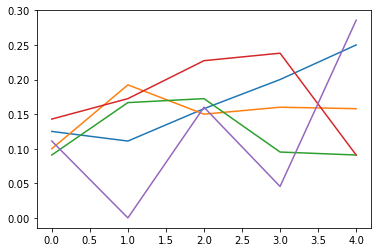

In [112]:
for ii in range(5):
    to_plot_keys = keys[ii*5:(ii+1)*5]
    to_plot = []
    for ind in [4,3,2,0,1]:
        to_plot.append(1- result_dict[to_plot_keys[ind]])
        print(to_plot_keys[ind], 1- result_dict[to_plot_keys[ind]])
    plt.plot(to_plot)

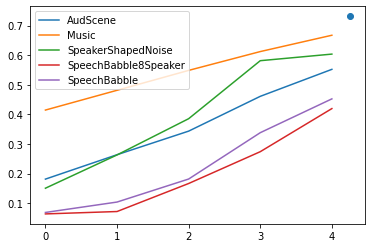

In [140]:
for ii in range(5,10):
    to_plot_keys = keys[ii*5:(ii+1)*5]
    to_plot = []
    for ind in [4,3,2,0,1]:
        to_plot.append(1- result_dict[to_plot_keys[ind]])
        #print(to_plot_keys[ind], 1- result_dict[to_plot_keys[ind]], old_net_results[to_plot_keys[ind][4:].replace('Speech','')])
    plt.plot(to_plot, label = to_plot_keys[0].split('_')[1])
plt.legend()
plt.scatter( 4.25, 1- result_dict['WSJDry'])

In [109]:
# Human results

In [110]:
results = [0.65956558061821224, 0.69334481172512774, 0.50913528245693807, 0.32581453634085211, 0.19703425229741017, 0.50187969924812026, 0.60054302422723471, 0.31893166919441979, 0.19256474519632411, 0.083208020050125314, 0.53220551378446113, 0.60043946534699355, 0.21881097420856263, 0.077025898078529664, 0.022305764411027568, 0.70133866459432692, 0.7741594530140129, 0.68809523809523798, 0.67957393483709272, 0.51984126984126977, 0.68554702114462585, 0.72293233082706754, 0.53504594820384288, 0.34001670843776105, 0.13291562238930654, 0.77341269841269844]

In [111]:
cat = [u'AudScene_0db', u'AudScene_3db', u'AudScene_neg3db', u'AudScene_neg6db', u'AudScene_neg9db', u'Babble2Spkr_0db', u'Babble2Spkr_3db', u'Babble2Spkr_neg3db', u'Babble2Spkr_neg6db', u'Babble2Spkr_neg9db', u'Babble8Spkr_0db', u'Babble8Spkr_3db', u'Babble8Spkr_neg3db', u'Babble8Spkr_neg6db', u'Babble8Spkr_neg9db', u'Music_0db', u'Music_3db', u'Music_neg3db', u'Music_neg6db', u'Music_neg9db', u'SpeakerShapedNoise_0db', u'SpeakerShapedNoise_3db', u'SpeakerShapedNoise_neg3db', u'SpeakerShapedNoise_neg6db', u'SpeakerShapedNoise_neg9db', u'dry']

In [148]:
# Naturalistic Network WSJ + TIMIT
old_net_results = {'Music_0db': 0.64423076923076927, 'AudScene_0db': 0.43243243243243246, 'Babble8Speaker_3db': 0.40322580645161288, 'Babble8Speaker_neg6db': 0.055555555555555552, 'Babble2Speaker_3db': 0.49056603773584906, 'AudScene_neg9db': 0.11965811965811966, 'Music_3db': 0.61467889908256879, 'SpeakerShapedNoise_neg3db': 0.34862385321100919, 'Babble8Speaker_0db': 0.33673469387755101, 'Babble2Speaker_neg6db': 0.12195121951219512, 'Babble8Speaker_neg9db': 0.027777777777777776, 'Babble8Speaker_neg3db': 0.18253968253968253, 'SpeakerShapedNoise_0db': 0.60683760683760679, 'SpeakerShapedNoise_neg6db': 0.29457364341085274, 'Babble2Speaker_0db': 0.31666666666666665, 'dry': 0.78125, 'SpeakerShapedNoise_3db': 0.59523809523809523, 'SpeakerShapedNoise_neg9db': 0.13084112149532709, 'AudScene_3db': 0.63809523809523805, 'Music_neg6db': 0.49166666666666664, 'Music_neg3db': 0.5901639344262295, 'Babble2Speaker_neg3db': 0.14529914529914531, 'Babble2Speaker_neg9db': 0.064220183486238536, 'Music_neg9db': 0.45132743362831856, 'bad': 0.36656053555392276, 'AudScene_neg3db': 0.34579439252336447, 'AudScene_neg6db': 0.22807017543859648}








In [122]:
human_dict = {}
for ii, entry in enumerate(cat):
    human_dict[entry] = results[ii]

['AudScene_0db', 'AudScene_3db', 'AudScene_neg3db', 'AudScene_neg6db', 'AudScene_neg9db', 'Babble2Spkr_0db', 'Babble2Spkr_3db', 'Babble2Spkr_neg3db', 'Babble2Spkr_neg6db', 'Babble2Spkr_neg9db', 'Babble8Spkr_0db', 'Babble8Spkr_3db', 'Babble8Spkr_neg3db', 'Babble8Spkr_neg6db', 'Babble8Spkr_neg9db', 'Music_0db', 'Music_3db', 'Music_neg3db', 'Music_neg6db', 'Music_neg9db', 'SpeakerShapedNoise_0db', 'SpeakerShapedNoise_3db', 'SpeakerShapedNoise_neg3db', 'SpeakerShapedNoise_neg6db', 'SpeakerShapedNoise_neg9db', 'dry']
['AudScene_0db', 'AudScene_3db', 'AudScene_neg3db', 'AudScene_neg6db', 'AudScene_neg9db', 'Babble2Spkr_0db', 'Babble2Spkr_3db', 'Babble2Spkr_neg3db', 'Babble2Spkr_neg6db', 'Babble2Spkr_neg9db', 'Babble8Spkr_0db', 'Babble8Spkr_3db', 'Babble8Spkr_neg3db', 'Babble8Spkr_neg6db', 'Babble8Spkr_neg9db', 'Music_0db', 'Music_3db', 'Music_neg3db', 'Music_neg6db', 'Music_neg9db', 'SpeakerShapedNoise_0db', 'SpeakerShapedNoise_3db', 'SpeakerShapedNoise_neg3db', 'SpeakerShapedNoise_neg6db', 

Text(0.5, 1.0, 'human performance')

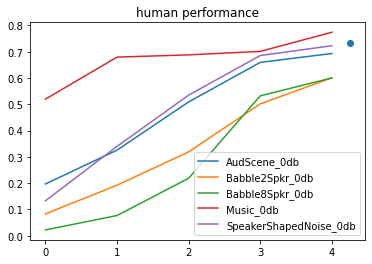

In [134]:
to_plot_keys = sorted(human_dict.keys())
print(to_plot_keys)

for ii in range(5):
    keys = to_plot_keys[ii*5:(ii+1)*5]
    print(to_plot_keys)
    to_plot = []
    for ind in [4,3,2,0,1]:
        to_plot.append(human_dict[keys[ind]])
        #print(to_plot_keys[ind], 1- result_dict[to_plot_keys[ind]], old_net_results[to_plot_keys[ind][4:].replace('Speech','')])
    plt.plot(to_plot, label = keys[0])
plt.legend()
plt.scatter( 4.25, 1- result_dict['WSJDry'])



plt.title('human performance')

In [141]:
old_net_results = {'Music_0db': 0.64423076923076927, 'AudScene_0db': 0.43243243243243246, 'Babble8Speaker_3db': 0.40322580645161288, 'Babble8Speaker_neg6db': 0.055555555555555552, 'Babble2Speaker_3db': 0.49056603773584906, 'AudScene_neg9db': 0.11965811965811966, 'Music_3db': 0.61467889908256879, 'SpeakerShapedNoise_neg3db': 0.34862385321100919, 'Babble8Speaker_0db': 0.33673469387755101, 'Babble2Speaker_neg6db': 0.12195121951219512, 'Babble8Speaker_neg9db': 0.027777777777777776, 'Babble8Speaker_neg3db': 0.18253968253968253, 'SpeakerShapedNoise_0db': 0.60683760683760679, 'SpeakerShapedNoise_neg6db': 0.29457364341085274, 'Babble2Speaker_0db': 0.31666666666666665, 'dry': 0.78125, 'SpeakerShapedNoise_3db': 0.59523809523809523, 'SpeakerShapedNoise_neg9db': 0.13084112149532709, 'AudScene_3db': 0.63809523809523805, 'Music_neg6db': 0.49166666666666664, 'Music_neg3db': 0.5901639344262295, 'Babble2Speaker_neg3db': 0.14529914529914531, 'Babble2Speaker_neg9db': 0.064220183486238536, 'Music_neg9db': 0.45132743362831856, 'bad': 0.36656053555392276, 'AudScene_neg3db': 0.34579439252336447, 'AudScene_neg6db': 0.22807017543859648}





['AudScene_0db', 'AudScene_3db', 'AudScene_neg3db', 'AudScene_neg6db', 'AudScene_neg9db', 'Babble2Speaker_0db', 'Babble2Speaker_3db', 'Babble2Speaker_neg3db', 'Babble2Speaker_neg6db', 'Babble2Speaker_neg9db', 'Babble8Speaker_0db', 'Babble8Speaker_3db', 'Babble8Speaker_neg3db', 'Babble8Speaker_neg6db', 'Babble8Speaker_neg9db', 'Music_0db', 'Music_3db', 'Music_neg3db', 'Music_neg6db', 'Music_neg9db', 'SpeakerShapedNoise_0db', 'SpeakerShapedNoise_3db', 'SpeakerShapedNoise_neg3db', 'SpeakerShapedNoise_neg6db', 'SpeakerShapedNoise_neg9db', 'bad', 'dry']
['AudScene_0db', 'AudScene_3db', 'AudScene_neg3db', 'AudScene_neg6db', 'AudScene_neg9db', 'Babble2Speaker_0db', 'Babble2Speaker_3db', 'Babble2Speaker_neg3db', 'Babble2Speaker_neg6db', 'Babble2Speaker_neg9db', 'Babble8Speaker_0db', 'Babble8Speaker_3db', 'Babble8Speaker_neg3db', 'Babble8Speaker_neg6db', 'Babble8Speaker_neg9db', 'Music_0db', 'Music_3db', 'Music_neg3db', 'Music_neg6db', 'Music_neg9db', 'SpeakerShapedNoise_0db', 'SpeakerShapedNoi

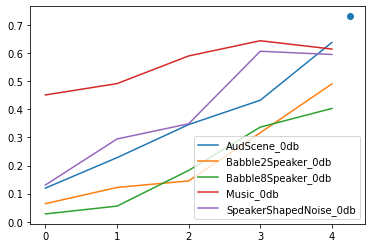

In [142]:
to_plot_keys = sorted(old_net_results.keys())
for ii in range(5):
    keys = to_plot_keys[ii*5:(ii+1)*5]
    print(to_plot_keys)
    to_plot = []
    for ind in [4,3,2,0,1]:
        to_plot.append(old_net_results[keys[ind]])
        #print(to_plot_keys[ind], 1- result_dict[to_plot_keys[ind]], old_net_results[to_plot_keys[ind][4:].replace('Speech','')])
    plt.plot(to_plot, label = keys[0])
plt.legend()
plt.scatter( 4.25, 1- result_dict['WSJDry'])



['WSJ_AudScene_0db', 'WSJ_AudScene_3db', 'WSJ_AudScene_neg3db', 'WSJ_AudScene_neg6db', 'WSJ_AudScene_neg9db']
['WSJ_Music_0db', 'WSJ_Music_3db', 'WSJ_Music_neg3db', 'WSJ_Music_neg6db', 'WSJ_Music_neg9db']
['WSJ_SpeakerShapedNoise_0db', 'WSJ_SpeakerShapedNoise_3db', 'WSJ_SpeakerShapedNoise_neg3db', 'WSJ_SpeakerShapedNoise_neg6db', 'WSJ_SpeakerShapedNoise_neg9db']
['WSJ_SpeechBabble8Speaker_0db', 'WSJ_SpeechBabble8Speaker_3db', 'WSJ_SpeechBabble8Speaker_neg3db', 'WSJ_SpeechBabble8Speaker_neg6db', 'WSJ_SpeechBabble8Speaker_neg9db']
['WSJ_SpeechBabble_0db', 'WSJ_SpeechBabble_3db', 'WSJ_SpeechBabble_neg3db', 'WSJ_SpeechBabble_neg6db', 'WSJ_SpeechBabble_neg9db']


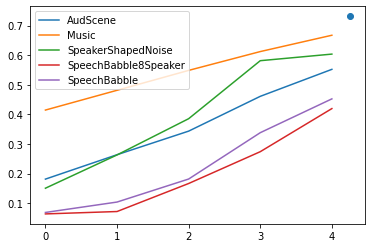

In [146]:
keys = sorted(result_dict.keys())
keys.remove('TimitDry')
keys.remove('WSJDry')

for ii in range(5,10):
    to_plot_keys = keys[ii*5:(ii+1)*5]
    print(to_plot_keys)
    to_plot = []
    for ind in [4,3,2,0,1]:
        to_plot.append(1- result_dict[to_plot_keys[ind]])
        #print(to_plot_keys[ind], 1- result_dict[to_plot_keys[ind]], old_net_results[to_plot_keys[ind][4:].replace('Speech','')])
    plt.plot(to_plot, label = to_plot_keys[0].split('_')[1])
plt.legend()
plt.scatter( 4.25, 1- result_dict['WSJDry'])